<a href="https://colab.research.google.com/github/Suhit97/Sentiment-Analysis/blob/master/LSTM%2BConv1D%20using%20keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import csv
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline





In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Sentiment/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
df = pd.read_csv('/content/gdrive/My Drive/Cleaned_text2.csv',
                 encoding = 'latin',header=None, index_col=None)
df.head()

,0,1,2,3,4,5,6
0,0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats bummer shoulda got david carr third...
1,1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting might cry r...
2,2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save rest go bounds
3,3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving im mad cant see


In [6]:
df.drop([0],axis=1,inplace=True)
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)
df.head()

,sentiment,text
0,Negative,awww thats bummer shoulda got david carr third...
1,Negative,upset cant update facebook texting might cry r...
2,Negative,dived many times ball managed save rest go bounds
3,Negative,whole body feels itchy like fire
4,Negative,behaving im mad cant see


In [7]:
df.text=df.text.astype(str)

In [8]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [9]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))


Train Data size: 1280000
Test Data size 320000


In [19]:
train_data.head(10)

,sentiment,text
23786,Negative,need friends
182699,Negative,im trying call impossible
476661,Negative,good pace going min missed turn ended waved thru
1181490,Positive,u gonna shows ny soon ive luv see u live
878773,Positive,hell yea get em tattoos ink free wish parents ...
130866,Negative,yeah need see ur mom calls back first remembr ...
1235876,Positive,sounds like cup tea sign
717314,Negative,im tired dont want sleep wtf
969880,Positive,amazing wish
748698,Negative,thank god wkrn abc affiliate nashville back ag...


In [10]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

## Tokenization¶

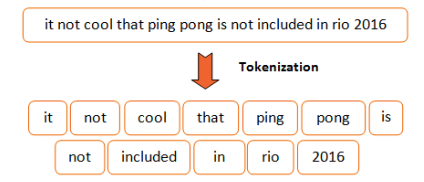

In [11]:
from keras.preprocessing.text import Tokenizer


Using TensorFlow backend.


In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 360959


In [13]:
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences

In [14]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


## Label Encoding

We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.


In [15]:
labels = train_data.sentiment.unique().tolist()

In [16]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


## Word Emdedding

In Language Model, words are represented in a way to intend more meaning and for learning the patterns and contextual meaning behind it.

Word Embedding is one of the popular representation of document vocabulary.It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Basically, it's a feature vector representation of words which are used for other natural language processing applications.

We could train the embedding ourselves but that would take a while to train and it wouldn't be effective. So going in the path of Computer Vision, here we use Transfer Learning. We download the pre-trained embedding and use it in our model.

The pretrained Word Embedding like GloVe & Word2Vec gives more insights for a word which can be used for classification. If you want to learn more about the Word Embedding, please refer some links that I left at the end of this notebook.

In this notebook, I use GloVe Embedding from Stanford AI 

In [28]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip.1 -d /content/gdrive/My\ Drive/Sentiment

--2020-07-03 08:24:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-07-03 08:24:43--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-07-03 08:24:43--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [29]:
!unzip glove.6B.zip.1 -d /content/gdrive/My\ Drive/Sentiment

Archive:  glove.6B.zip.1
  inflating: /content/gdrive/My Drive/Sentiment/glove.6B.50d.txt  
  inflating: /content/gdrive/My Drive/Sentiment/glove.6B.100d.txt  
  inflating: /content/gdrive/My Drive/Sentiment/glove.6B.200d.txt  
  inflating: /content/gdrive/My Drive/Sentiment/glove.6B.300d.txt  


In [17]:
GLOVE_EMB = '/content/gdrive/My Drive/Sentiment/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10

In [18]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [19]:


embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector



In [20]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

## Model Training - LSTM
For model architecture, we use

1) Embedding Layer - Generates Embedding Vector for each input sequence.

2) Conv1D Layer - Its using to convolve data into smaller feature vectors.

3) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4) Dense - Fully Connected Layers for classification

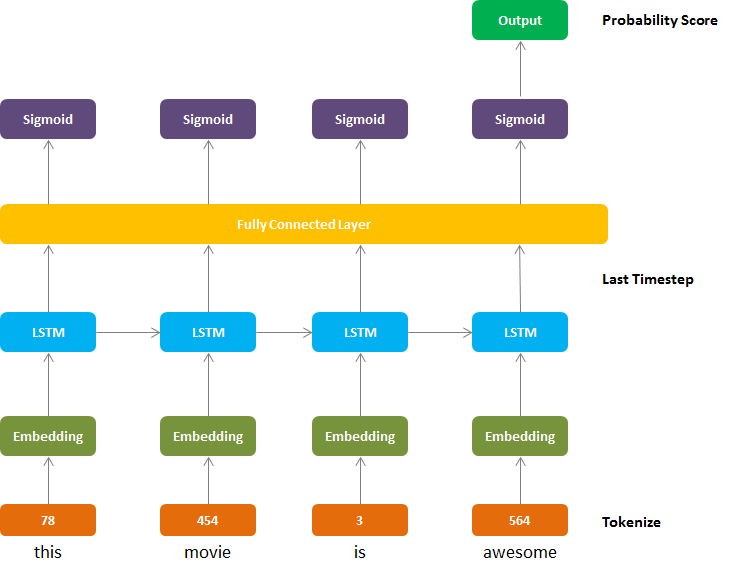

In [21]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [22]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           108287700 
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

## Optimization Algorithm

This notebook uses Adam, optimization algorithm for Gradient Descent.

Callbacks are special functions which are called at the end of an epoch. We can use any functions to perform specific operation after each epoch. I used two callbacks here,

    LRScheduler - It changes a Learning Rate at specfic epoch to achieve more improved result. In this notebook, the learning rate exponentionally decreases after remaining same for first 10 Epoch.

    ModelCheckPoint - It saves best model while training based on some metrics. Here, it saves the model with minimum Validity Loss.



In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [26]:


print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")



Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Training on GPU...


In [27]:


history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])



Epoch 1/10
1250/1250 [==============================] - 121s 97ms/step - loss: 0.5125 - accuracy: 0.7452 - val_loss: 0.4773 - val_accuracy: 0.7684 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 121s 96ms/step - loss: 0.4796 - accuracy: 0.7686 - val_loss: 0.4639 - val_accuracy: 0.7788 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 122s 98ms/step - loss: 0.4684 - accuracy: 0.7755 - val_loss: 0.4573 - val_accuracy: 0.7818 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 122s 98ms/step - loss: 0.4620 - accuracy: 0.7796 - val_loss: 0.4570 - val_accuracy: 0.7844 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 123s 98ms/step - loss: 0.4575 - accuracy: 0.7824 - val_loss: 0.4524 - val_accuracy: 0.7858 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 122s 98ms/step - loss: 0.4542 - accuracy: 0.7844 - val_loss: 0.4509 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 7/10
1250/1250 [==================

## Model Evaluation

Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.


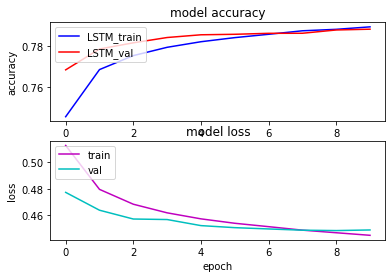

In [28]:


s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')



The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as POSITIVE sentiment.


In [29]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 3s 108ms/step


## Confusion Matrix

Confusion Matrix provide a nice overlook at the model's performance in classification task


In [30]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

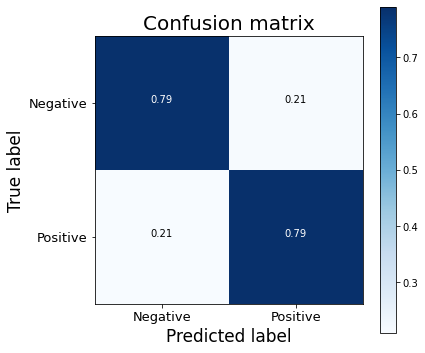

In [31]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()


In [32]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.79      0.79      0.79    160542
    Positive       0.79      0.79      0.79    159458

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [33]:
MODEL_PATH = '/content/gdrive/My Drive/Sentiment/sent_lstm_conv1.hdf5'

In [34]:
from tensorflow.keras.models import load_model
# save entire model to HDF5 
model.save(MODEL_PATH)